In [13]:
#import data science packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook

import glob
import sys


plt.rcParams["font.family"] = "Arial"

sys.path.append('/Users/bencekover/Library/CloudStorage/OneDrive-Personal/MSci Bahler lab/S.-Pombe-MLPs - Github/')

import yeastmlptrial.flocculation as flo

root = "/Users/bencekover/Library/CloudStorage/OneDrive-Personal/MSci Bahler lab/S.-Pombe-MLPs - Github/"

#strain maps 
new_wild_isolate_map = root + "internal data/final wild strain map.xlsx"
segregant_map = root + "internal data/segregant_strains_map.xlsx"

# Segregants on EMM 

(<Figure size 640x480 with 2 Axes>, <Axes: >)

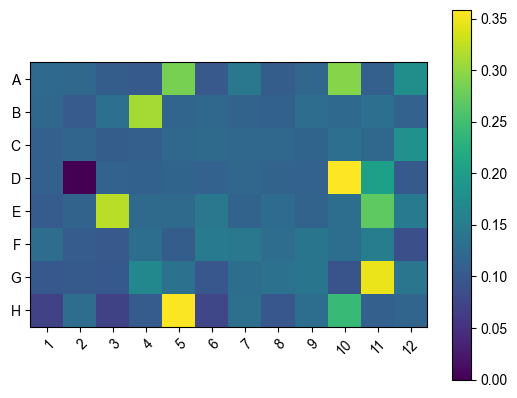

In [14]:
#strain data folders
folder_seg_emm= root + "internal data/flocculation_plate_reader_data/Segregants_EMM/"
segregants_emm = flo.folder_to_results(folder_seg_emm,[10,10,10,10,10], 37, segregant_map, groupby="Position")
flo.heatmap_from_df(segregants_emm)

# Compare with filtering measurements

In [15]:
#import /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Phenotypes/filtering_results.csv separator \
filtering_results = pd.read_csv(root + "internal data/Filtering assay/filtering_results.csv", sep="\t")
#groupby Strain and take mean %flocc
filtering_results = filtering_results.groupby("Strain").mean()

In [16]:
strains = pd.read_excel(segregant_map, header=None)
#RENAME COLUMNS 1-12, INDICES A-H
strains = strains.rename(columns={0:"1", 1:"2", 2:"3", 3:"4", 4:"5", 5:"6", 6:"7", 7:"8", 8:"9", 9:"10", 10:"11", 11:"12"})
strains = strains.rename(index={0:"A", 1:"B", 2:"C", 3:"D", 4:"E", 5:"F", 6:"G", 7:"H"})


In [17]:
#loop through position in CV_df and get the strain from strains
strain_list = []
for i in segregants_emm.index:
    #get row and column by splitting the position as the first character being the index and the rest being the column
    row = i[0]
    column = i[1:]
    #get the strain from strains
    strain = strains.loc[row, column]
    strain_list.append(strain)
#add the strain list to CV_df
segregants_emm["Strain"] = strain_list
#merge CV_df with filtering_results on Strain
CV_df_final_seg = segregants_emm.merge(filtering_results, on="Strain")
#remove any strain that starts with JB
CV_df_final_seg = CV_df_final_seg[~CV_df_final_seg["Strain"].str.startswith("JB")]


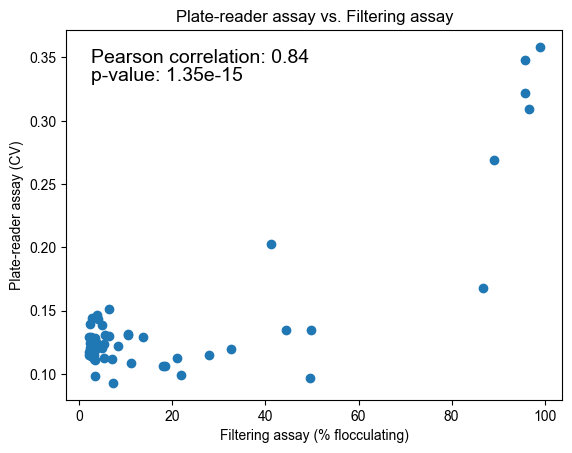

In [18]:
#plot CV vs %flocc
import scipy.stats as st
fig, ax = plt.subplots()
ax.scatter(CV_df_final_seg["%flocc"],CV_df_final_seg["CV"])
ax.set_xlabel("Filtering assay (% flocculating)")
ax.set_ylabel("Plate-reader assay (CV)")

#make it pretty and put pearson correlation on the plot
ax.set_title("Plate-reader assay vs. Filtering assay")
#print pearson correlation
ax.text(0.05, 0.95, "Pearson correlation: " + str(round(st.pearsonr(CV_df_final_seg["%flocc"],CV_df_final_seg["CV"])[0], 2)), transform=ax.transAxes, fontsize=14, verticalalignment='top')
#print p-value
ax.text(0.05, 0.9, "p-value: " + str(round(st.pearsonr(CV_df_final_seg["%flocc"],CV_df_final_seg["CV"])[1], 17)), transform=ax.transAxes, fontsize=14, verticalalignment='top')


plt.savefig(root + "Figures/All figures/filtering_vs_platereader.svg", format="svg", dpi=400)
plt.savefig(root + "Figures/All figures/filtering_vs_platereader.png", format="png", dpi=400)

/Users/bencekover/Library/CloudStorage/OneDrive-Personal/MSci Bahler lab/S.-Pombe-MLPs - Github/yeastmlptrial/flocculation.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.index, rotation=90)


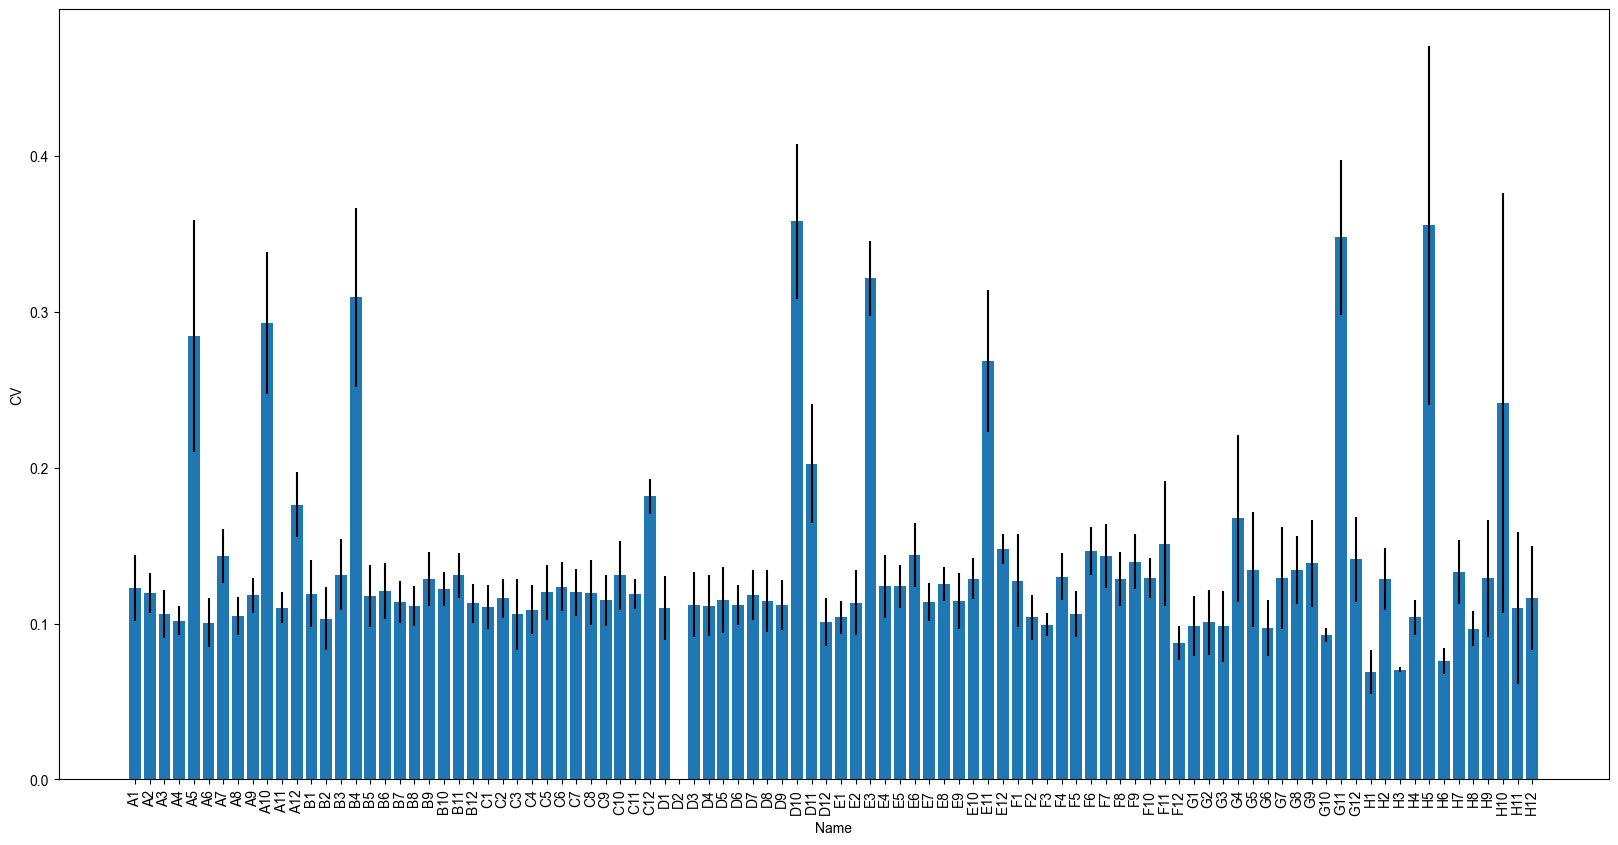

In [19]:
flo.barchart_from_df(segregants_emm)


# Repeat for wild isolates

In [20]:
strains_wi = pd.read_excel(root + "internal data/final wild strain map.xlsx",header=None)
#RENAME COLUMNS 1-12, INDICES A-H
strains_wi = strains_wi.rename(columns={0:"1", 1:"2", 2:"3", 3:"4", 4:"5", 5:"6", 6:"7", 7:"8", 8:"9", 9:"10", 10:"11", 11:"12"})
strains_wi = strains_wi.rename(index={0:"A", 1:"B", 2:"C", 3:"D", 4:"E", 5:"F", 6:"G", 7:"H"})
strains_wi 


,1,2,3,4,5,6,7,8,9,10,11,12
A,JB50,JB759,JB50,JB759,JB50,JB759,JB50,JB759,JB50,JB759,JB50,JB759
B,JB759,JB50,JB1110,JB1117,JB1154,JB1171,JB1174,JB1180,JB1197,JB1205,JB1206,JB50
C,JB50,JB759,JB1207,JB22,JB4,JB758,JB760,JB762,JB837,JB838,JB840,JB759
D,JB759,JB841,JB842,JB845,JB846,JB848,JB852,JB853,JB854,JB858,JB862,JB50
E,JB50,JB864,JB869,JB870,JB871,JB872,JB873,JB874,JB875,JB878,JB879,JB759
F,JB759,JB884,JB899,JB900,JB902,JB910,JB913,JB914,JB916,JB917,JB918,JB50
G,JB50,JB929,JB930,JB931,JB934,JB938,JB939,JB942,JB943,JB953,EMPTY,JB759
H,JB759,JB50,JB759,JB50,JB759,JB50,JB759,JB50,JB759,JB50,JB759,JB50


(<Figure size 640x480 with 2 Axes>, <Axes: >)

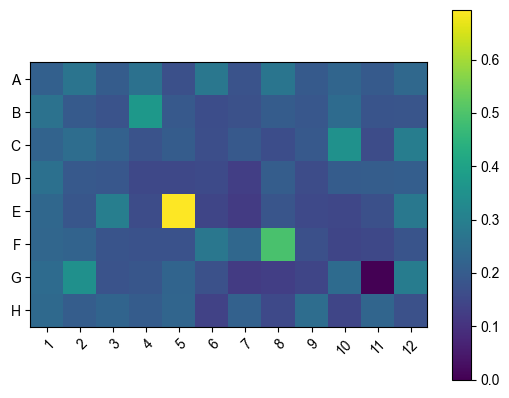

In [21]:
#strain data folders
folder_wi_emm= "/Users/bencekover/Library/CloudStorage/OneDrive-Personal/MSci Bahler lab/S.-Pombe-MLPs - Github/internal data/flocculation_plate_reader_data/Wild Isolates_EMM"
wi_map = root + "internal data/final wild strain map.xlsx"
wi_emm = flo.folder_to_results(folder_wi_emm,[9,9,10,10,10,15,15,15,15,15,15], 82, wi_map, groupby="Position")
flo.heatmap_from_df(wi_emm)




/Users/bencekover/Library/CloudStorage/OneDrive-Personal/MSci Bahler lab/S.-Pombe-MLPs - Github/yeastmlptrial/flocculation.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.index, rotation=90)


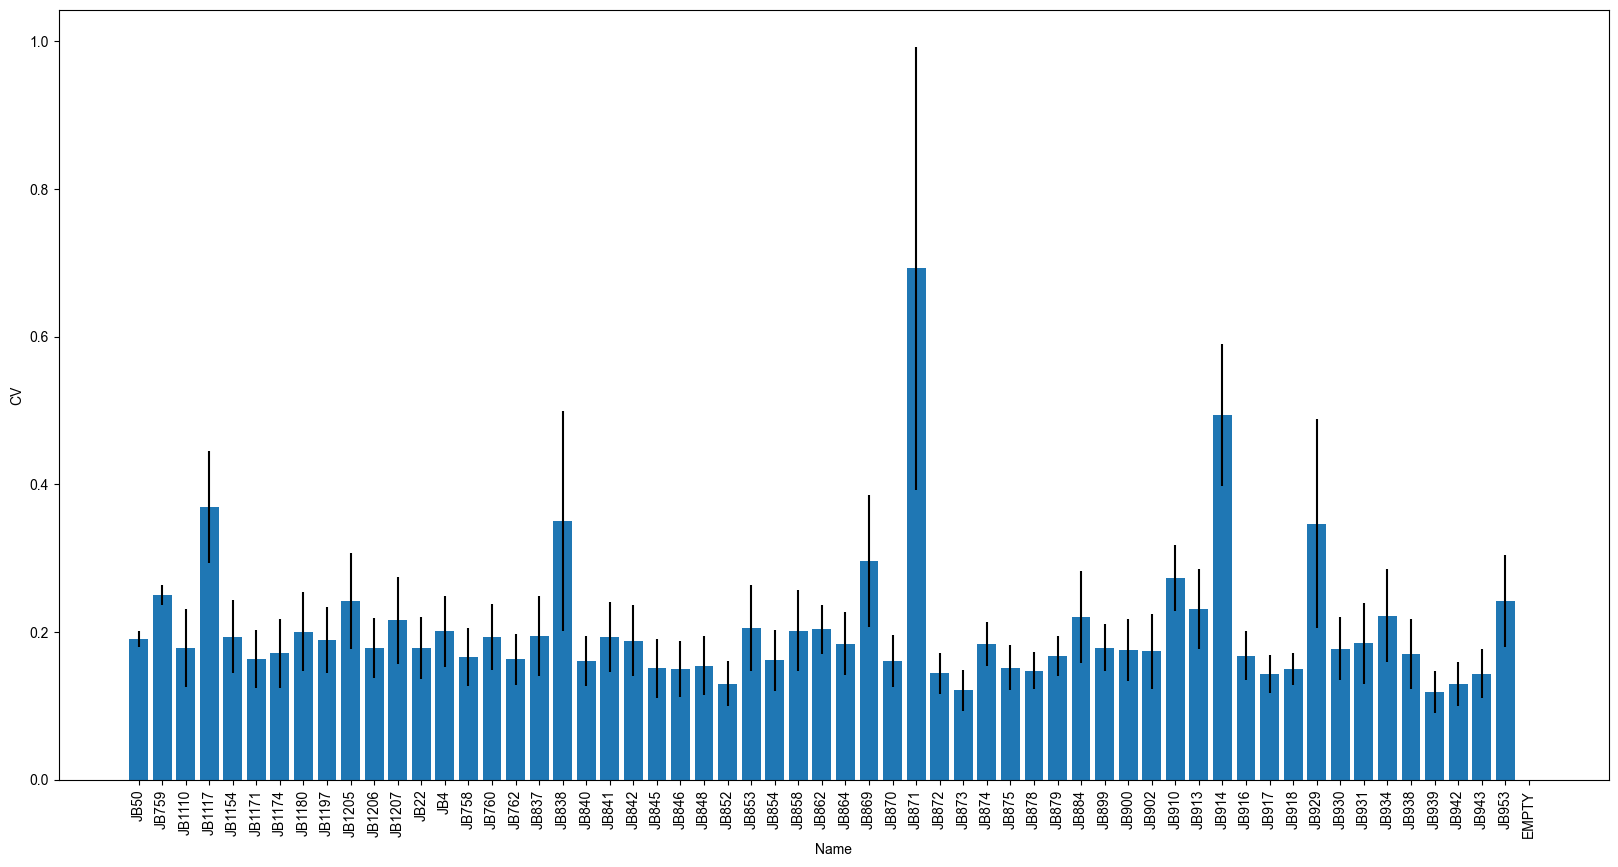

In [22]:
wi_emm = flo.folder_to_results(folder_wi_emm,[9,9,10,10,10,15,15,15,15,15,15], 82, wi_map, groupby="Strain")
wi_emm.to_csv(root + "Bence folder/Plate_reader_assay/plate_reader_wild_isolates_results.csv")
flo.barchart_from_df(wi_emm)

# Rep for wild isolates YES

(<Figure size 640x480 with 2 Axes>, <Axes: >)

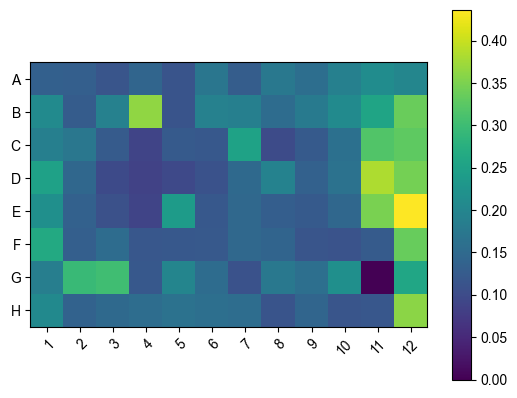

In [23]:
folder_wi_yes= "/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-MLPs/internal data/flocculation_plate_reader_data/Wild Isolates_YES"
wi_map = root + "internal data/final wild strain map.xlsx"
wi_yes = flo.folder_to_results(folder_wi_yes,10, 82, wi_map, groupby="Position")
flo.heatmap_from_df(wi_yes)

/Users/bencekover/Library/CloudStorage/OneDrive-Personal/MSci Bahler lab/S.-Pombe-MLPs - Github/yeastmlptrial/flocculation.py:144: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.index, rotation=90)


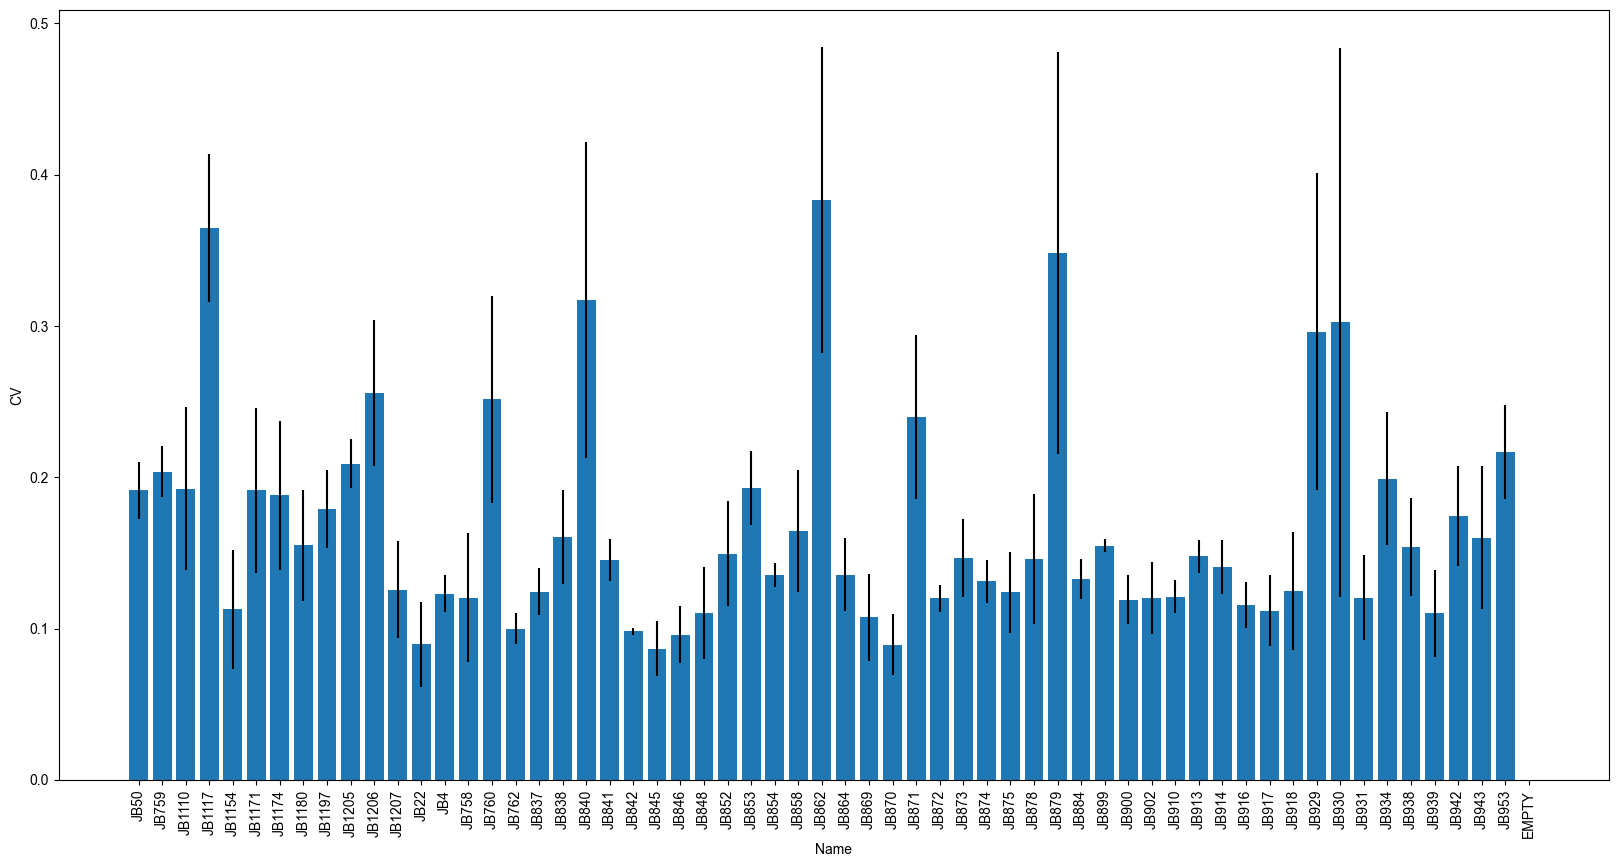

In [24]:
wi_yes = flo.folder_to_results(folder_wi_yes,10, 82, wi_map, groupby="Strain")
flo.barchart_from_df(wi_yes)

In [25]:
%load_ext watermark
%watermark


Last updated: 2023-11-04T12:45:21.900047+00:00

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 7.31.1

Compiler    : Clang 11.0.0 
OS          : Darwin
Release     : 21.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [26]:
%watermark --iversions



matplotlib: 3.8.0
sys       : 3.9.0 | packaged by conda-forge | (default, Nov 26 2020, 07:54:06) 
[Clang 11.0.0 ]
pandas    : 1.4.4
scipy     : 1.11.3
bokeh     : 3.2.2
numpy     : 1.23.4

